In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import EfficientNetB3
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
image_size = 300
batch_size = 16

In [3]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
train_path = '../input/cassava-leaf-disease-classification/train_images'

train_path_second = '../input/more-cassava-disease/train/train/train'

In [4]:
second_id = []
second_label = []

for img in os.listdir(os.path.join(train_path_second, 'cbb')):
    second_id.append('/cbb/'+img)
    second_label.append('0')
    
for img in os.listdir(os.path.join(train_path_second, 'cbsd')):
    second_id.append('/cbsd/'+img)
    second_label.append('1')
    
for img in os.listdir(os.path.join(train_path_second, 'cgm')):
    second_id.append('/cgm/'+img)
    second_label.append('2')
    
for img in os.listdir(os.path.join(train_path_second, 'cmd')):
    second_id.append('/cmd/'+img)
    second_label.append('3')
    
for img in os.listdir(os.path.join(train_path_second, 'healthy')):
    second_id.append('/healthy/'+img)
    second_label.append('4')

In [5]:
train_second = pd.DataFrame({'image_id':second_id, 'label':second_label})

train_second.head()

,image_id,label
0,/cbb/train-cbb-0.jpg,0
1,/cbb/train-cbb-1.jpg,0
2,/cbb/train-cbb-10.jpg,0
3,/cbb/train-cbb-100.jpg,0
4,/cbb/train-cbb-101.jpg,0


In [6]:
del second_id
del second_label

In [7]:
def image_path_first(image):
    return os.path.join(train_path,image)

def image_path_second(image):
    return os.path.join(train_path_second, image)

train['image_id'] = train['image_id'].apply(image_path_first)
train_second['image_id'] = train_second['image_id'].apply(image_path_second)

In [8]:
train['label'] = train['label'].astype('str')

In [9]:
# combine dataframe to train

combined_train = pd.concat([train, train_second], ignore_index=True)

combined_train.head()

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,0
1,../input/cassava-leaf-disease-classification/t...,3
2,../input/cassava-leaf-disease-classification/t...,1
3,../input/cassava-leaf-disease-classification/t...,1
4,../input/cassava-leaf-disease-classification/t...,3


In [10]:
combined_train.tail()

,image_id,label
27048,/healthy/train-healthy-95.jpg,4
27049,/healthy/train-healthy-96.jpg,4
27050,/healthy/train-healthy-97.jpg,4
27051,/healthy/train-healthy-98.jpg,4
27052,/healthy/train-healthy-99.jpg,4


In [11]:
del train
del train_second

train = combined_train

del combined_train
del train_path
del train_path_second

In [12]:
train.tail()

,image_id,label
27048,/healthy/train-healthy-95.jpg,4
27049,/healthy/train-healthy-96.jpg,4
27050,/healthy/train-healthy-97.jpg,4
27051,/healthy/train-healthy-98.jpg,4
27052,/healthy/train-healthy-99.jpg,4


In [13]:
from sklearn.model_selection import StratifiedKFold

SKF = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

In [14]:
train_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                                horizontal_flip=True, vertical_flip=True, fill_mode='nearest', brightness_range=[0.7, 1.3],
                                rotation_range=270, zoom_range=0.2, shear_range=10, width_shift_range=0.2, height_shift_range=0.2,
                                rescale = 1./255)

val_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, rescale=1./255)

In [15]:
def build_efficientnet_b3():
    model = Sequential()
    model.add(EfficientNetB3(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    return model

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


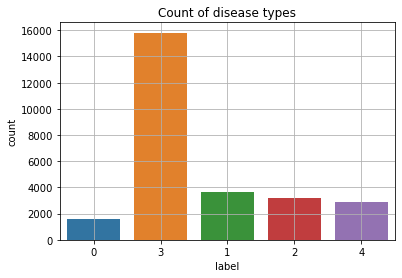

In [16]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of disease types')
plt.grid()
plt.show()

In [17]:
fold_var = 1

In [18]:
for train_idx, val_idx in SKF.split(train, train['label']):
    training_data = train.iloc[train_idx]
    validation_data = train.iloc[val_idx]
    
    # generator
    train_generator = train_gen.flow_from_dataframe(dataframe=training_data, directory=None, x_col='image_id', y_col='label',
                                                batch_size=batch_size, seed=1, shuffle=True,
                                                class_mode='categorical', target_size=(image_size,image_size))

    validation_generator = val_gen.flow_from_dataframe(dataframe=validation_data, directory=None, x_col='image_id', y_col='label',
                                                   batch_size=batch_size, seed=1, shuffle=False,
                                                   class_mode='categorical', target_size=(image_size,image_size))
    
    print('Fold num:', fold_var)
    print('Train length:', len(train_generator))
    print('Val length:', len(validation_generator))
    
    # build model
    model = build_efficientnet_b3()
    
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    
    # callbacks
    checkpoint_filename = './k_fold_effnet/checkpoint_' + str(fold_var) + '.h5'
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=1, min_lr=0, verbose=1)
    
    # fit
    history = model.fit(train_generator, epochs=30, validation_data=validation_generator, verbose=1,
                        batch_size=batch_size,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])
                        
    # save model
    model_filename = './k_fold_effnet/' + str(fold_var) + '.h5'
    model.save(model_filename)
    
    clear_session()
    fold_var += 1

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4532 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1124 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17110 validated image filenames belonging to 5 classes.
Found 4287 validated image filenames belonging to 5 classes.
Fold num: 1
Train length: 1070
Val length: 268
Epoch 1/30
1070/1070 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.7434
Epoch 00001: val_loss improved from inf to 1.78438, saving model to ./k_fold_effnet\checkpoint_1.h5
1070/1070 [==============================] - 384s 359ms/step - loss: 0.7141 - accuracy: 0.7434 - val_loss: 1.7844 - val_accuracy: 0.3000
Epoch 2/30
1070/1070 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.8188
Epoch 00002: val_loss improved from 1.78438 to 1.37277, saving model to ./k_fold_effnet\checkpoint_1.h5
1070/1070 [==============================] - 387s 361ms/step - loss: 0.5178 - accuracy: 0.8188 - val_loss: 1.3728 - val_accuracy: 0.4733
Epoch 3/30
1070/1070 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.8412
Epoch 00003: val_loss did not improve from 1.37277

Epoch 

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4491 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1165 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17151 validated image filenames belonging to 5 classes.
Found 4246 validated image filenames belonging to 5 classes.
Fold num: 2
Train length: 1072
Val length: 266
Epoch 1/30
1072/1072 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.7468
Epoch 00001: val_loss improved from inf to 1.64895, saving model to ./k_fold_effnet\checkpoint_2.h5
1072/1072 [==============================] - 386s 360ms/step - loss: 0.7097 - accuracy: 0.7468 - val_loss: 1.6490 - val_accuracy: 0.2614
Epoch 2/30
1072/1072 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.8187
Epoch 00002: val_loss did not improve from 1.64895

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1072/1072 [==============================] - 380s 354ms/step - loss: 0.5286 - accuracy: 0.8187 - val_loss: 2.3175 - val_accuracy: 0.1705
Epoch 3/30
1072/1072 [==============================] - ETA: 0s - loss: 0.4496 - accuracy: 0.8435
Epoch 00003: val_loss improve

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4470 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1186 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17172 validated image filenames belonging to 5 classes.
Found 4225 validated image filenames belonging to 5 classes.
Fold num: 3
Train length: 1074
Val length: 265
Epoch 1/30
1074/1074 [==============================] - ETA: 0s - loss: 0.7084 - accuracy: 0.7477
Epoch 00001: val_loss improved from inf to 1.82931, saving model to ./k_fold_effnet\checkpoint_3.h5
1074/1074 [==============================] - 382s 356ms/step - loss: 0.7084 - accuracy: 0.7477 - val_loss: 1.8293 - val_accuracy: 0.3198
Epoch 2/30
1074/1074 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.8171
Epoch 00002: val_loss improved from 1.82931 to 1.42245, saving model to ./k_fold_effnet\checkpoint_3.h5
1074/1074 [==============================] - 380s 354ms/step - loss: 0.5209 - accuracy: 0.8171 - val_loss: 1.4224 - val_accuracy: 0.4026
Epoch 3/30
1074/1074 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.8374
Epoch 00003: val_loss did not improve from 1.42245

Epoch 

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4563 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1093 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17080 validated image filenames belonging to 5 classes.
Found 4317 validated image filenames belonging to 5 classes.
Fold num: 4
Train length: 1068
Val length: 270
Epoch 1/30
1068/1068 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.7426
Epoch 00001: val_loss improved from inf to 1.60570, saving model to ./k_fold_effnet\checkpoint_4.h5
1068/1068 [==============================] - 392s 367ms/step - loss: 0.7127 - accuracy: 0.7426 - val_loss: 1.6057 - val_accuracy: 0.2367
Epoch 2/30
1068/1068 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.8198
Epoch 00002: val_loss improved from 1.60570 to 1.41007, saving model to ./k_fold_effnet\checkpoint_4.h5
1068/1068 [==============================] - 390s 365ms/step - loss: 0.5184 - accuracy: 0.8198 - val_loss: 1.4101 - val_accuracy: 0.4825
Epoch 3/30
1068/1068 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.8410
Epoch 00003: val_loss did not improve from 1.41007

Epoch 

C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 4568 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 17075 validated image filenames belonging to 5 classes.
Found 4322 validated image filenames belonging to 5 classes.
Fold num: 5
Train length: 1068
Val length: 271


C:\Users\pomat\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1088 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/30
1068/1068 [==============================] - ETA: 0s - loss: 0.7219 - accuracy: 0.7405
Epoch 00001: val_loss improved from inf to 1.49216, saving model to ./k_fold_effnet\checkpoint_5.h5
1068/1068 [==============================] - 393s 368ms/step - loss: 0.7219 - accuracy: 0.7405 - val_loss: 1.4922 - val_accuracy: 0.3734
Epoch 2/30
1068/1068 [==============================] - ETA: 0s - loss: 0.5366 - accuracy: 0.8141
Epoch 00002: val_loss improved from 1.49216 to 1.43435, saving model to ./k_fold_effnet\checkpoint_5.h5
1068/1068 [==============================] - 391s 366ms/step - loss: 0.5366 - accuracy: 0.8141 - val_loss: 1.4343 - val_accuracy: 0.4137
Epoch 3/30
1068/1068 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.8357
Epoch 00003: val_loss did not improve from 1.43435

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1068/1068 [==============================] - 391s 366ms/step - loss: 0.4746 - accuracy: 0.8357 

In [20]:
test = pd.read_csv('../input/more-cassava-disease/sample_submission_file.csv')

In [21]:
test_path = '../input/more-cassava-disease/test/test/test/0'

def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)
test['label'].replace('cbb', '0', inplace=True)
test['label'].replace('cbsd', '1', inplace=True)
test['label'].replace('cgm', '2', inplace=True)
test['label'].replace('cmd', '3', inplace=True)
test['label'].replace('healthy', '4', inplace=True)

In [23]:
test_generator = val_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

Found 3774 validated image filenames belonging to 5 classes.


In [24]:
output = model.predict(test_generator)
output = np.argmax(output, axis=1)

In [25]:
from sklearn.metrics import classification_report

report = classification_report(test_generator.classes, output, target_names=['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy'])
print(report)

              precision    recall  f1-score   support

         CBB       0.22      0.08      0.12       753
        CBSD       0.18      0.18      0.18       731
         CGM       0.19      0.14      0.16       706
         CMD       0.22      0.45      0.29       800
     Healthy       0.21      0.15      0.17       784

    accuracy                           0.20      3774
   macro avg       0.20      0.20      0.19      3774
weighted avg       0.20      0.20      0.19      3774

